In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from scipy.stats import truncnorm
import arviz as az
import matplotlib as mpl
sns.set_style('white')

<h1>Prepare directories</h1>

In [2]:
import os

for directory in ['./output/', 
                  './output/figures/',
                  './output/tables',
                  './output/sims']:
    if not os.path.exists(directory):
        os.makedirs(directory)

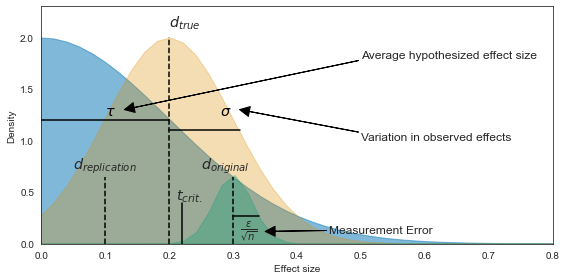

In [3]:
from src.plotting import fig_1
from src.theory import type_m_vec, type_s_vec, replicate_vec, publish_vec

#Move tau right (increase sigma, same for the green distribution)
fig = fig_1()

In [4]:
from src.plotting import fig_2,fig_3, SI_Theory_Fig1

(<Figure size 576x576 with 4 Axes>, <numpy.flatiter at 0x7fb5efe99800>)

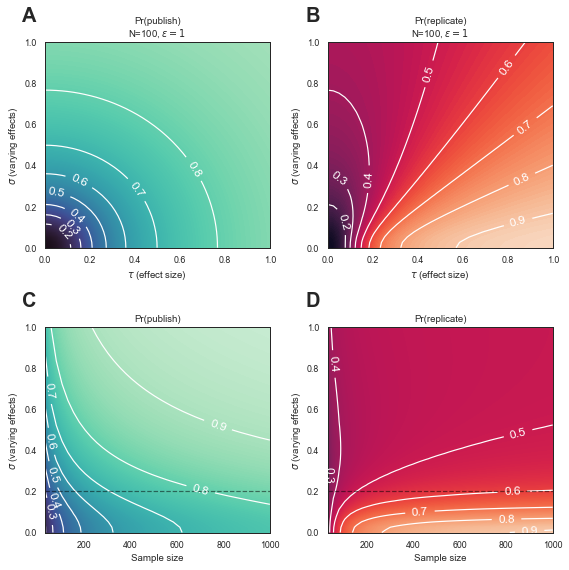

In [5]:
from src.plotting import fig_2,fig_3, SI_Theory_Fig1
fig_2()

In [ ]:
fig_3()

In [ ]:
SI_Theory_Fig1('./output/figures/SIFigurePTrue10percentN100.png')

In [ ]:
SI_Theory_Fig1(N=1000, output='./output/figures/SIFigurePTrue10percentN1000.png')

In [ ]:
sns.set_context('paper',font_scale=1)
sns.set_palette(sns.color_palette("mako"))

fig, axs = plt.subplots(1,3,figsize=(12,4))

p_true = .1
res = 20
N=1000

axs0 = axs[0]
sns.set_context('paper')
x= np.linspace(0, 1.0, res)
y = np.linspace(0.01,1.0, res)
X, Y =  np.meshgrid(x,y)
Z1 = publish_vec(tau=0.01, sigma=Y, epsilon=1, n=N)
Z2 = publish_vec(tau=X, sigma=Y, epsilon=1, n=N)
Z = p_true* Z1 + (1-p_true) * Z2

lls = np.linspace(.2,1,9)
CS= axs0.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs0.clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
CSF= axs0.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("mako",as_cmap=True))
axs0.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs0.set_xlabel(r'$\tau$' + ' (effect size)')
axs0.set_title('Pr(publish)\n' +'N=50, ' + r'$\epsilon=1$')


axs1 = axs[1]
x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z1 = replicate_vec(X, Y, 1, N, .05)
Z2 = replicate_vec(0.01, Y,1,N,.05)
Z = p_true * Z1 + (1-p_true) * Z2

CS= axs1.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs1.clabel(CS, colors = 'w', fontsize=12) 

levels = np.linspace(.0,1,100)
CSF= axs1.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs1.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs1.set_xlabel(r'$\tau$' + ' (effect size)')
axs1.set_title('Pr(replicate)\n' +'N=50, ' + r'$\epsilon=1$')



x= np.linspace(0.001, 1, res)
y = np.linspace(0.001,1, res)
X, Y =  np.meshgrid(x,y)
Z1 = type_s_vec(X, Y,1,N,.05) 
Z2 = type_s_vec(0.01, Y,1,N,.05) 
Z = p_true * Z1 + (1-p_true) * Z2

lls = np.linspace(0,.5,11)
CS= axs[2].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[2].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(0,.5,100)
CSF= axs[2].contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("ch:start=2.8,rot=.3",as_cmap=True))
axs[2].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[2].set_xlabel(r'$\tau$' + ' (effect size)')
axs[2].set_title('Type-S error') 

import string
axs = axs.flat
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.tight_layout()
plt.savefig('./output/figures/SIFigurePTrue10percentN1000.png',dpi=300)